### 0.0. Dependencies and Data

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import rfpimp

In [100]:
retail_areas = pd.read_csv("retail_areas_final.csv")

In [101]:
print(retail_areas.dtypes)

date                                                       object
id                                                          int64
events                                                      int64
weekend                                                      bool
season                                                     object
holiday                                                      bool
Local_Footprint_Centre_ID                                  object
Residential Population (Weighted Catchment)                 int64
Retail Footprint Score                                    float64
Base Score                                                float64
Tourism Score                                             float64
Convenience_Score                                         float64
Retail_Footprint_Comparison_Retailer_Score                float64
Leisure_Footprint_Score                                   float64
Auto_Score                                                float64
Local Foot

In [102]:
print("Number of unique Local_Footprint_Centre_ID:", retail_areas['Local_Footprint_Centre_ID'].nunique())
print("Total number of rows:", len(retail_areas))

Number of unique Local_Footprint_Centre_ID: 1448
Total number of rows: 524131


In [153]:
unique_days = retail_areas.loc[retail_areas['mean_wind'].isna(), 'date'].unique()
unique_days_sorted = sorted(unique_days)
print("Unique days with missing mean_wind:", unique_days_sorted)

Unique days with missing mean_wind: ['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-13', '2024-01-14', '2024-01-25', '2024-02-09', '2024-03-01', '2024-03-02', '2024-03-03', '2024-03-04', '2024-03-07', '2024-03-08', '2024-03-09', '2024-03-10', '2024-03-11', '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-23', '2024-05-15', '2024-05-16', '2024-05-17', '2024-05-18', '2024-05-19', '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17', '2024-06-21', '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27', '2024-06-28', '2024-07-05', '2024-07-06', '2024-07-07', '2024-08-05', '2024-08-13', '2024-08-14', '2024-08-15', '2024-08-16', '2024-08-17', '2024-08-18', '2024-08-19', '2024-08-28', '2024-08-29', '2024-08-30', '2024-08-31', '2024-09-01', '2024-09-02', '2024-09-03', '2024-09-11', '2024-10-07', '2024-10-12', '2024-10-13', '2024-10-30

### 1.1. Model Prep

#### 1.1.1. Check for linear relationships

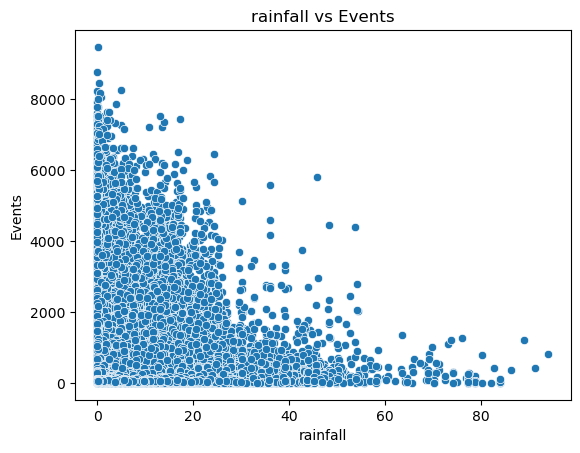

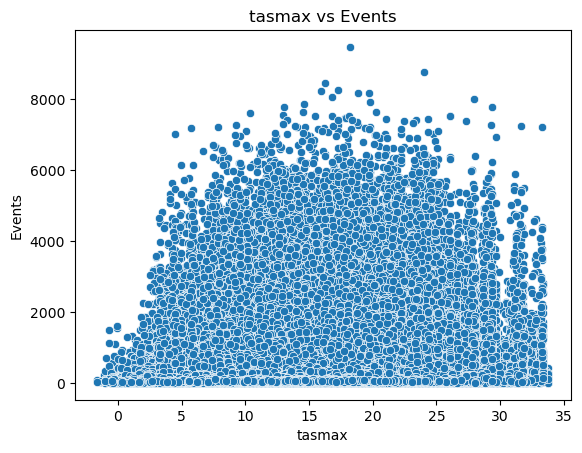

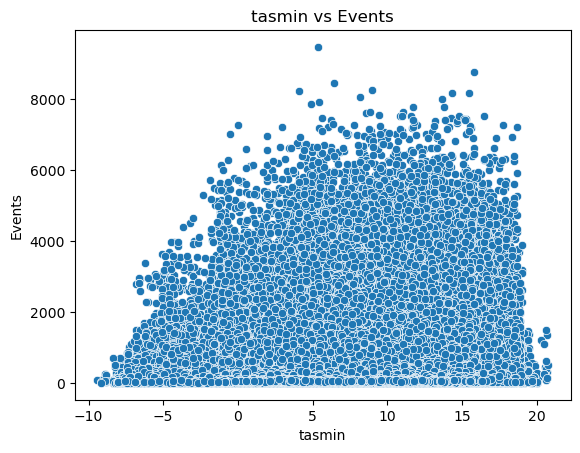

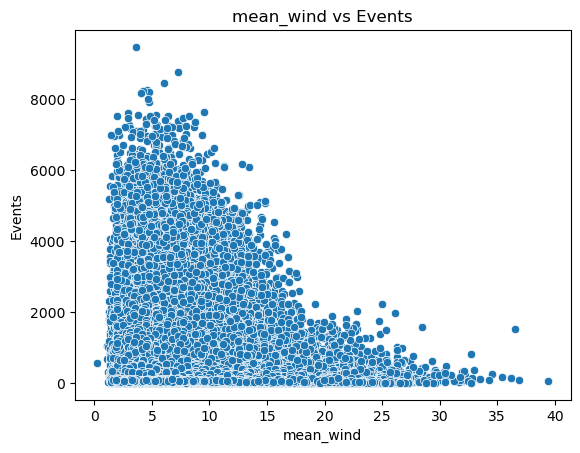

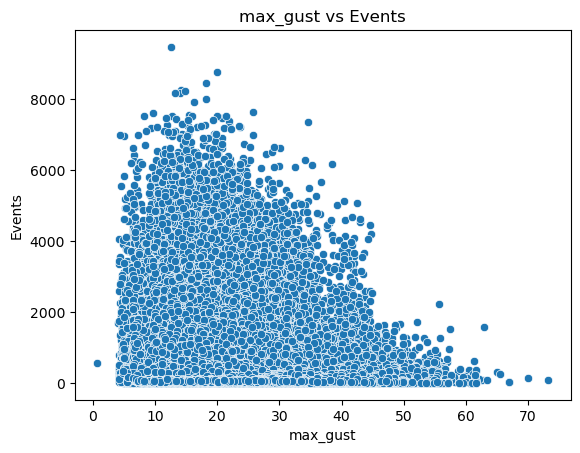

In [104]:
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']

for var in weather_vars:
    sns.scatterplot(x=var, y='events', data=retail_areas)
    plt.title(f'{var} vs Events')
    plt.xlabel(var)
    plt.ylabel('Events')
    plt.show()

#### 1.1.2. Var encoding

In [105]:
# copy to avoid modifying original
df_model = retail_areas.copy()

df_model = df_model.drop(['Minor_Class_Name', 'Major_Class_Name', 'Seasonality_Class_Name'], axis=1)

# binary encode 'coastal'
df_model['coastal'] = df_model['coastal'].map({'coastal': 1, 'inland': 0})

# one-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region', 'groupName']
df_model = pd.get_dummies(df_model, columns=cat_vars, drop_first=True)

# drop missing values
print(df_model.isnull().sum()[df_model.isnull().sum() > 0])
num_rows_with_missing = df_model.isnull().any(axis=1).sum()
print(f"Rows with at least one missing value: {num_rows_with_missing}")
print(f"Total rows before drop: {len(df_model)}")
df_model = df_model.dropna()
print(f"Total rows after drop: {len(df_model)}")

Tourism Score      1411
rainfall           3976
tasmax             3976
tasmin             3976
mean_wind        158739
max_gust         158739
dtype: int64
Rows with at least one missing value: 162502
Total rows before drop: 524131
Total rows after drop: 361629


### 1.2. General Model

#### 1.2.1. Most basic without weather

In [106]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'weekend',
    'holiday',
    ] + [col for col in df_model.columns if col.startswith('season_')]

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [107]:
print(df_model.groupby('date')['id'].nunique())

date
2024-01-15    1408
2024-01-16    1410
2024-01-17    1408
2024-01-18    1412
2024-01-19    1417
              ... 
2024-11-20    1419
2024-11-25    1422
2024-11-26    1417
2024-11-27    1421
2024-12-02    1417
Name: id, Length: 255, dtype: int64


In [108]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical. The index indicates which rows from the original data.

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(289303, 6)
(289303,)
(72326, 6)
(72326,)
True
True


Hyperparameters:

In [109]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END ..................max_depth=20, min_samples_split=2; total time=  14.3s
[CV] END .................max_depth=10, min_samples_split=10; total time=  14.9s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  16.3s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  16.5s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  16.6s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  16.0s
[CV] END ..................max_depth=30, min_samples_split=4; total time=  15.1s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  16.6s
[CV] END ..................max_depth=30, min_samples_split=8; total time=  15.1s
[CV] END ..................max_depth=30, min_samples_split=6; total time=  15.2s
[CV] END .................max_depth=40, min_samples_split=10; total time=  14.9s
[CV] END ..................max_depth=40, min_samples_split=6; total time=  15.0s
[CV] END ..................m

Model random forest:

In [110]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

RandomForestRegressor(random_state=10000)

In [111]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.6793028260771682
R² on the testing data:
0.661958238836232


In [112]:
rf_final = RandomForestRegressor(**clf.best_params_, 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

RandomForestRegressor(max_depth=30, min_samples_split=10, random_state=10000)

In [113]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.6792786126311726
R² on the testing data:
0.6621634860830674


In [114]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
355.9808656906249
RMSE on the testing data:
368.4582372788902


                                             Importance
Feature                                                
Residential Population (Weighted Catchment)    1.305083
season_Winter                                  0.023463
season_Spring                                  0.018405
season_Summer                                  0.005150
weekend                                        0.003660
holiday                                       -0.003712


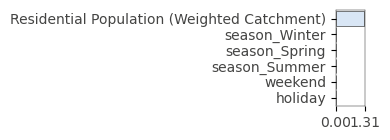

In [115]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 1.2.2. Add score variables

Train/test:

In [116]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_')]

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [117]:
print(df_model.groupby('date')['id'].nunique())

date
2024-01-15    1408
2024-01-16    1410
2024-01-17    1408
2024-01-18    1412
2024-01-19    1417
              ... 
2024-11-20    1419
2024-11-25    1422
2024-11-26    1417
2024-11-27    1421
2024-12-02    1417
Name: id, Length: 255, dtype: int64


In [118]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical. The index indicates which rows from the original data.

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(289303, 9)
(289303,)
(72326, 9)
(72326,)
True
True


Hyperparameters:

In [119]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................max_depth=10, min_samples_split=4; total time=  24.7s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  25.1s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  24.9s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  25.4s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  25.5s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  25.6s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  26.0s
[CV] END .................max_depth=10, min_samples_split=10; total time=  25.1s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  25.8s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  26.1s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  25.9s
[CV] END ..................max_depth=10, min_sa

Model random forest:

In [120]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

RandomForestRegressor(random_state=10000)

In [121]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:


0.9439422815171746
R² on the testing data:
0.939016025757529


In [122]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

RandomForestRegressor(max_depth=20, min_samples_split=10, random_state=10000)

In [123]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.943775404389566
R² on the testing data:
0.9391241962138682


In [124]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
149.0479009289115
RMSE on the testing data:
156.4074123008142


                                             Importance
Feature                                                
Leisure_Footprint_Score                        1.239622
Tourism Score                                  0.451148
Retail Footprint Score                         0.396254
Residential Population (Weighted Catchment)    0.269858
season_Winter                                  0.045144
season_Spring                                  0.032683
weekend                                        0.018199
season_Summer                                  0.009243
holiday                                        0.001286


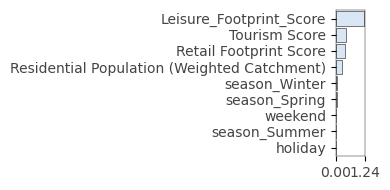

In [125]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 1.2.3. Add weather

Train/test:

In [126]:
# define target and features
target = 'events'
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + weather_vars + [col for col in df_model.columns if col.startswith('season_')]

# split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [127]:
print(features)

['Residential Population (Weighted Catchment)', 'Tourism Score', 'Retail Footprint Score', 'Leisure_Footprint_Score', 'weekend', 'holiday', 'rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust', 'season_Spring', 'season_Summer', 'season_Winter']


In [128]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(289303, 14)
(289303,)
(72326, 14)
(72326,)
True
True


Hyperparameters:

In [129]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.9min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.9min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.9min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.9min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.9min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.9min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.9min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.9min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.9min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.9min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.9min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.9min
[CV] END ..................m

Model random forest:

In [130]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

RandomForestRegressor(random_state=10000)

In [131]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9908713861202267
R² on the testing data:
0.9360868105828182


In [132]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

RandomForestRegressor(max_depth=20, min_samples_split=10, random_state=10000)

In [133]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.972161142199882
R² on the testing data:
0.9378535396502251


In [134]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
104.87896677948886
RMSE on the testing data:
158.03132282628775


                                             Importance
Feature                                                
Leisure_Footprint_Score                        1.242347
Tourism Score                                  0.471385
Retail Footprint Score                         0.351412
Residential Population (Weighted Catchment)    0.250586
season_Winter                                  0.038889
weekend                                        0.016436
season_Spring                                  0.015580
tasmax                                         0.005384
mean_wind                                      0.004294
season_Summer                                  0.004185
tasmin                                         0.002924
holiday                                        0.000834
max_gust                                       0.000422
rainfall                                       0.000065


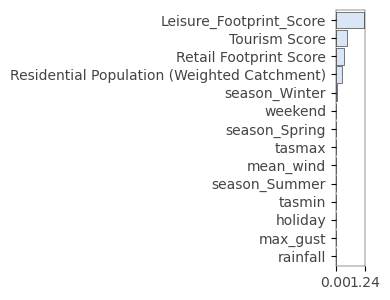

In [135]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 1.2.4. Add retail type

Train/test:

In [136]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + weather_vars  + [col for col in df_model.columns 
                     if col.startswith('season_') or col.startswith('groupName_')] 

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [137]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(289303, 21)
(289303,)
(72326, 21)
(72326,)
True
True


Hyperparameters:

In [138]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 2.1min
[CV] END .................max_depth=10, min_samples_split=10; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 2.1min
[CV] END ..................max_depth=10, min_sa

[CV] END ..................max_depth=50, min_samples_split=2; total time= 3.6min
[CV] END ..................max_depth=50, min_samples_split=2; total time= 3.6min
[CV] END ..................max_depth=40, min_samples_split=2; total time= 3.6min
[CV] END ..................max_depth=50, min_samples_split=2; total time= 3.6min
[CV] END ..................max_depth=50, min_samples_split=2; total time= 3.6min
[CV] END ..................max_depth=40, min_samples_split=2; total time= 3.6min
[CV] END ..................max_depth=40, min_samples_split=2; total time= 3.7min
The best parameter value is: 
{'max_depth': 20, 'min_samples_split': 10}
The best score is: 
0.9353624374526124


Model random forest:

In [139]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

RandomForestRegressor(random_state=10000)

In [140]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9908930224879019
R² on the testing data:
0.9360937384607905


In [141]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

RandomForestRegressor(max_depth=20, min_samples_split=10, random_state=10000)

In [142]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9714194435466766
R² on the testing data:
0.9377986303177244


In [143]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
106.26690547030053
RMSE on the testing data:
158.10112148035526


                                                    Importance
Feature                                                       
Leisure_Footprint_Score                               1.366344
Tourism Score                                         0.404411
groupName_Indie high streets                          0.231204
Retail Footprint Score                                0.226519
Residential Population (Weighted Catchment)           0.132751
groupName_Local urban convenience centres             0.071879
season_Winter                                         0.026041
season_Spring                                         0.023711
weekend                                               0.017742
groupName_Secondary retail parks and shopping c...    0.009205
tasmax                                                0.005861
groupName_Primary shopping centres and premium ...    0.005743
groupName_Sub-regional retail and leisure desti...    0.005360
rainfall                                              0

/workspace/.conda/lib/python3.11/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


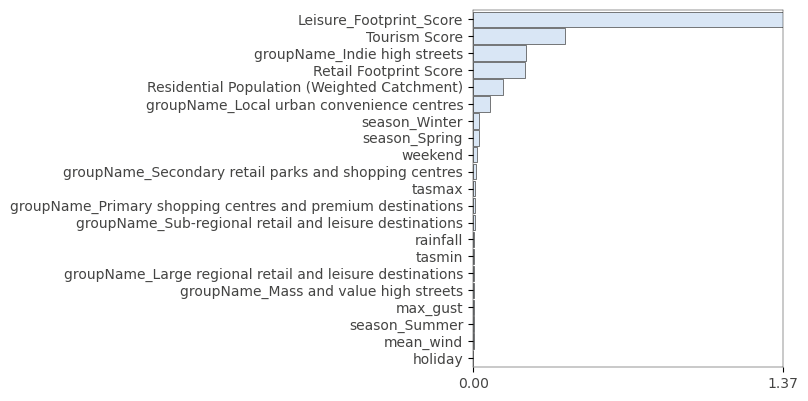

In [144]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

### 1.3. Model per retail type

In [145]:
# copy to avoid modifying original
df_model = retail_areas.copy()

df_model = df_model.drop(['Minor_Class_Name', 'Major_Class_Name'], axis=1)

# binary encode 'coastal'
df_model['coastal'] = df_model['coastal'].map({'coastal': 1, 'inland': 0})

# One-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region']
            #'supergroupName', 'groupName']
df_model = pd.get_dummies(df_model, columns=cat_vars, drop_first=True)

print(df_model.isnull().sum())
num_rows_with_missing = df_model.isnull().any(axis=1).sum()
print(f"Rows with at least one missing value: {num_rows_with_missing}")
print(f"Total rows before drop: {len(df_model)}")
df_model = df_model.dropna()
print(f"Total rows after drop: {len(df_model)}")

date                               0
id                                 0
events                             0
weekend                            0
holiday                            0
                                  ..
Region_South East                  0
Region_South West                  0
Region_Wales                       0
Region_West Midlands               0
Region_Yorkshire and The Humber    0
Length: 71, dtype: int64
Rows with at least one missing value: 164022
Total rows before drop: 524131
Total rows after drop: 360109


#### 1.3.1. Without weather

Model:

In [146]:
group_col = 'groupName'
randomState_dt = 10000

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
    'Tourism Score',
] + [col for col in df_model.columns if col.startswith('season_')]

for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # skip small groups

    # train-test split per group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    model = RandomForestRegressor(random_state=randomState_dt).fit(train_x, train_y)
    
    # scores
    r2_train = model.score(train_x, train_y)
    r2_test = model.score(test_x, test_y)

    importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    print(f"\nGroup: {name}")
    print(f"R² (train): {r2_train:.3f} | R² (test): {r2_test:.3f}")
    print("Feature Importances:")
    print(importances.round(3))



Group: District urban service centres
R² (train): 0.962 | R² (test): 0.958
Feature Importances:
Leisure_Footprint_Score                        0.578
Retail Footprint Score                         0.208
Tourism Score                                  0.137
Residential Population (Weighted Catchment)    0.042
season_Winter                                  0.013
season_Spring                                  0.011
weekend                                        0.007
season_Summer                                  0.004
holiday                                        0.002
dtype: float64

Group: Indie high streets
R² (train): 0.871 | R² (test): 0.853
Feature Importances:
Leisure_Footprint_Score                        0.491
Tourism Score                                  0.230
Retail Footprint Score                         0.122
Residential Population (Weighted Catchment)    0.083
season_Winter                                  0.025
season_Spring                                  0.019
weekend 

Add calibration:

In [147]:
# loop over groups
for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # Skip small groups

    # split train/test within each group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    # hyperparameter tuning for this group
    rf = RandomForestRegressor(random_state=randomState_dt)
    hyperparameters = {'max_depth': [10, 20, 30, 40, 50],
                       'min_samples_split': [2, 4, 6, 8, 10]}
    
    clf = GridSearchCV(rf, hyperparameters, cv=5, n_jobs=-1)
    clf.fit(train_x, train_y)

    print(f"\nGroup: {name}")
    print("Best parameters:", clf.best_params_)
    print("Best CV R² score:", round(clf.best_score_, 3))

    # fit tuned model
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    ).fit(train_x, train_y)

    # evaluate
    r2_train = model.score(train_x, train_y)
    r2_test = model.score(test_x, test_y)
    importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    print(f"R² (train): {r2_train:.3f} | R² (test): {r2_test:.3f}")
    print("Feature Importances:")
    print(importances.round(3))




Group: District urban service centres
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Best CV R² score: 0.957
R² (train): 0.962 | R² (test): 0.958
Feature Importances:
Leisure_Footprint_Score                        0.578
Retail Footprint Score                         0.204
Tourism Score                                  0.141
Residential Population (Weighted Catchment)    0.041
season_Winter                                  0.013
season_Spring                                  0.011
weekend                                        0.007
season_Summer                                  0.004
holiday                                        0.002
dtype: float64

Group: Indie high streets
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Best CV R² score: 0.857
R² (train): 0.871 | R² (test): 0.853
Feature Importances:
Leisure_Footprint_Score                        0.493
Tourism Score                                  0.229
Retail Footprint Score                         0.121

#### 1.3.2. With weather

In [148]:
group_col = 'groupName'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
    'Tourism Score',
] + weather_vars + [col for col in df_model.columns if 
                    col.startswith('season_')]

for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # skip small groups

    # train-test split per group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    model = RandomForestRegressor(random_state=randomState_dt).fit(train_x, train_y)
    
    # Scores
    r2_train = model.score(train_x, train_y)
    r2_test = model.score(test_x, test_y)

    importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    print(f"\nGroup: {name}")
    print(f"R² (train): {r2_train:.3f} | R² (test): {r2_test:.3f}")
    print("Feature Importances:")
    print(importances.round(3))


Group: District urban service centres
R² (train): 0.994 | R² (test): 0.957
Feature Importances:
Leisure_Footprint_Score                        0.557
Retail Footprint Score                         0.198
Tourism Score                                  0.134
Residential Population (Weighted Catchment)    0.040
season_Winter                                  0.012
tasmax                                         0.011
season_Spring                                  0.010
tasmin                                         0.009
rainfall                                       0.007
mean_wind                                      0.007
max_gust                                       0.007
weekend                                        0.006
season_Summer                                  0.001
holiday                                        0.001
dtype: float64



Group: Indie high streets
R² (train): 0.979 | R² (test): 0.845
Feature Importances:
Leisure_Footprint_Score                        0.431
Tourism Score                                  0.201
Retail Footprint Score                         0.105
Residential Population (Weighted Catchment)    0.074
tasmax                                         0.034
tasmin                                         0.030
mean_wind                                      0.025
max_gust                                       0.024
rainfall                                       0.024
season_Winter                                  0.019
season_Spring                                  0.015
weekend                                        0.010
season_Summer                                  0.005
holiday                                        0.001
dtype: float64

Group: Large regional retail and leisure destinations
R² (train): 0.986 | R² (test): 0.908
Feature Importances:
Leisure_Footprint_Score                      

Add calibration:

In [150]:
# loop over groups
for name, group_data in df_model.groupby(group_col):
    if len(group_data) < 30:
        continue  # Skip small groups

    # split train/test within each group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    # hyperparameter tuning for this group
    rf = RandomForestRegressor(random_state=randomState_dt)
    hyperparameters = {'max_depth': [10, 20, 30, 40, 50],
                       'min_samples_split': [2, 4, 6, 8, 10]}
    
    clf = GridSearchCV(rf, hyperparameters, cv=5, n_jobs=1)
    clf.fit(train_x, train_y)

    print(f"\nGroup: {name}")
    print("Best parameters:", clf.best_params_)
    print("Best CV R² score:", round(clf.best_score_, 3))

    # fit tuned model
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    ).fit(train_x, train_y)

    # evaluate
    r2_train = model.score(train_x, train_y)
    r2_test = model.score(test_x, test_y)
    importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

    print(f"R² (train): {r2_train:.3f} | R² (test): {r2_test:.3f}")
    print("Feature Importances:")
    print(importances.round(3))


KeyboardInterrupt: 

In [ ]:
print(df_model['holiday'].value_counts())

holiday
False    512915
True      11216
Name: count, dtype: int64


Partial dependence plots:

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

for name, group_data in df_model.groupby('groupName'):
    if len(group_data) < 30:
        continue  # Skip small groups

    X = group_data[weather_vars].copy()
    y = group_data['events']

    # Handle missing values (robustness)
    X = X.fillna(X.median())

    # Fit tuned model
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    ).fit(X, y)

    # Prepare layout
    n_features = len(weather_vars)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    ax = np.atleast_1d(ax).flatten()

    # Plot partial dependence
    PartialDependenceDisplay.from_estimator(
        model,
        X,
        features=weather_vars,
        ax=ax[:n_features]
    )

    for axis in ax[:n_features]:
        axis.set_ylim(0, 1500)  # Optional: adjust y-limits for interpretability

    plt.suptitle(f'Partial Dependence - {name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

NameError: name 'math' is not defined

### 1.4. Retail model per sparsity

- London
- Other urban
- Rural 
- Coastal

In [ ]:
#...

#### later

Leisure footprint?
rail/tube--- specifically for london?

Train/test:

In [ ]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns 
     if col.startswith('season_')]

# split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [ ]:
print(features)

['Residential Population (Weighted Catchment)', 'Tourism Score', 'Retail Footprint Score', 'Leisure_Footprint_Score', 'weekend', 'holiday', 'season_Spring', 'season_Summer', 'season_Winter', 'groupName_Indie high streets', 'groupName_Large regional retail and leisure destinations', 'groupName_Local urban convenience centres', 'groupName_Mass and value high streets', 'groupName_Primary shopping centres and premium destinations', 'groupName_Secondary retail parks and shopping centres', 'groupName_Sub-regional retail and leisure destinations']


In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(289303, 9)
(289303,)
(72326, 9)
(72326,)
True
True


Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................max_depth=10, min_samples_split=2; total time=  55.5s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  56.0s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  56.0s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  59.5s
[CV] END .................max_depth=10, min_samples_split=10; total time=  56.5s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  57.3s
[CV] END .................max_depth=10, min_samples_split=10; total time=  57.4s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  58.3s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  58.5s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  58.5s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  59.1s
[CV] END ..................max_depth=10, min_sa

Model random forest:

In [ ]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

RandomForestRegressor(random_state=10000)

In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9439422815171746
R² on the testing data:
0.939016025757529


In [ ]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

RandomForestRegressor(max_depth=30, min_samples_split=6, random_state=10000)

In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9372260532518457
R² on the testing data:
0.9307798770000343


In [ ]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
156.48655217032308
RMSE on the testing data:
164.52627186415876


                                             Importance
Feature                                                
Leisure_Footprint_Score                        1.162253
Tourism Score                                  0.455117
Retail Footprint Score                         0.366579
Residential Population (Weighted Catchment)    0.246387
season_Winter                                  0.034506
season_Spring                                  0.031154
weekend                                        0.014401
season_Summer                                  0.007182
holiday                                        0.001427


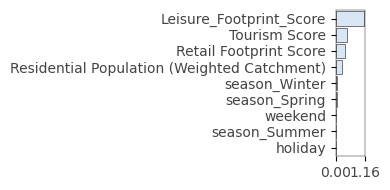

In [ ]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 1.2.4. With weather

Train/test:

In [ ]:
# define target and features
target = 'events'

# features list
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + weather_vars  + [col for col in df_model.columns 
                     if col.startswith('season_')] 

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(289303, 11)
(289303,)
(72326, 11)
(72326,)
True
True


Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 2.0min
[CV] END .................max_depth=10, min_samples_split=10; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 2.0min
[CV] END .................max_depth=10, min_samples_split=10; total time= 2.0min
[CV] END ..................max_depth=10, min_sa

Model random forest:

In [ ]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

RandomForestRegressor(random_state=10000)

In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9908713861202267
R² on the testing data:
0.9360868105828182


In [ ]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

RandomForestRegressor(max_depth=20, min_samples_split=10, random_state=10000)

In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9714194435466766
R² on the testing data:
0.9377986303177244


In [ ]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
106.26690547030053
RMSE on the testing data:
158.10112148035526


                                             Importance
Feature                                                
Leisure_Footprint_Score                        1.156042
Tourism Score                                  0.450586
Retail Footprint Score                         0.322407
Residential Population (Weighted Catchment)    0.213414
weekend                                        0.013824
tasmax                                         0.009230
tasmin                                         0.005394
mean_wind                                      0.003617
max_gust                                       0.002520
rainfall                                       0.000883
holiday                                        0.000743


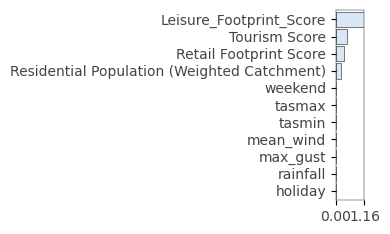

In [ ]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### Add typology

Train/test:

In [ ]:
# define target and features
target = 'events'

# features list
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + weather_vars  + [col for col in df_model.columns 
                     if col.startswith('season_') or col.startswith('groupName_')] 

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(289303, 21)
(289303,)
(72326, 21)
(72326,)
True
True


Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 2.0min
[CV] END .................max_depth=10, min_samples_split=10; total time= 2.0min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 2.0min
[CV] END .................max_depth=10, min_samples_split=10; total time= 2.0min
[CV] END ..................max_depth=10, min_sa

Model random forest:

In [ ]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

RandomForestRegressor(random_state=10000)

In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9908930224879019
R² on the testing data:
0.9360937384607905


In [ ]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

RandomForestRegressor(max_depth=20, min_samples_split=10, random_state=10000)

In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9714194435466766
R² on the testing data:
0.9377986303177244


In [ ]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
104.87896677948886
RMSE on the testing data:
158.03132282628775


                                                    Importance
Feature                                                       
Leisure_Footprint_Score                               1.359512
Tourism Score                                         0.464085
groupName_Indie high streets                          0.280403
Retail Footprint Score                                0.257832
Residential Population (Weighted Catchment)           0.143669
groupName_Local urban convenience centres             0.069759
season_Winter                                         0.035265
season_Spring                                         0.022191
weekend                                               0.021959
groupName_Secondary retail parks and shopping c...    0.008737
tasmax                                                0.005488
groupName_Primary shopping centres and premium ...    0.003662
season_Summer                                         0.003643
tasmin                                                0

/workspace/.conda/lib/python3.11/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


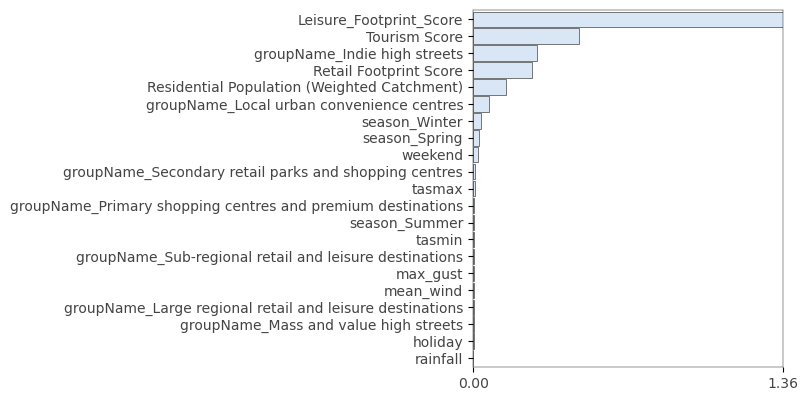

In [ ]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()